In [1]:
# ============================================================
# [단락 0] 라이브러리 + 한글 폰트
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ===============================
# 📌 한글 폰트 설정 (Windows)
# ===============================
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


df = pd.read_csv(
    r"C:\ai\lecNote\1st_project\data\금리시장면적_고용지표수정_인허가일자머지_인구머지_폐업률추가.csv",
    low_memory=False
)


In [2]:
# ============================================================
# [단락 1] 컬럼 정의
# ============================================================
num_cols = [
    "base_rate",
    "시설총규모",
    "인허가일자_경제활동참가율",
    "인허가일자_실업률",
    "인허가일자_고용률",
    "구별인구",
    "창업월",
]

cat_cols = [
    "업태_그룹",
    "구",
]

target_col = "폐업_3년이내"


In [34]:
# ============================================================
# [단락 3] Train/Test split (층화)
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (189894, 9) Test: (47474, 9)


In [35]:
# ============================================================
# [단락 4] 전처리 (수치: 결측+스케일 / 범주: 결측+원핫)
# ============================================================
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

Xt_train = preprocess.fit_transform(X_train)
Xt_test  = preprocess.transform(X_test)

Xt_train = Xt_train.toarray() if hasattr(Xt_train, "toarray") else Xt_train
Xt_test  = Xt_test.toarray()  if hasattr(Xt_test, "toarray") else Xt_test

print("After preprocess:", Xt_train.shape, Xt_test.shape)


After preprocess: (189894, 39) (47474, 39)


In [24]:
# ============================================================
# [단락 4] 전처리 (수치: 결측+스케일 / 범주: 결측+원핫)
# ============================================================
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

Xt_train = preprocess.fit_transform(X_train)
Xt_test  = preprocess.transform(X_test)

Xt_train = Xt_train.toarray() if hasattr(Xt_train, "toarray") else Xt_train
Xt_test  = Xt_test.toarray()  if hasattr(Xt_test, "toarray") else Xt_test

print("After preprocess:", Xt_train.shape, Xt_test.shape)


After preprocess: (189894, 39) (47474, 39)


In [36]:
# ============================================================
# [단락 5] class_weight (완화: sqrt) — 학습이 1을 너무 무시하지 않게
# ============================================================
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
w1 = float(np.sqrt(neg / max(pos, 1)))   # 완화 가중치
class_weight = {0: 1.0, 1: w1}

print("pos_ratio:", pos/(pos+neg), "| class_weight:", class_weight)


pos_ratio: 0.31125785964801417 | class_weight: {0: 1.0, 1: 1.4875383279530061}


In [37]:
# ============================================================
# [단락 6] 딥러닝 모델
# ============================================================
input_dim = Xt_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),

    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.30),

    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(64, activation="relu"),
    layers.Dropout(0.20),

    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        keras.metrics.AUC(name="auc"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.BinaryAccuracy(name="acc"),
    ]
)

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               10240     
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 128)              

In [38]:
# ============================================================
# [단락 7] 학습
# ============================================================
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=8,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc",
        mode="max",
        factor=0.5,
        patience=3,
        min_lr=1e-5,
        verbose=1
    )
]

history = model.fit(
    Xt_train, y_train,
    validation_split=0.2,
    epochs=60,
    batch_size=256,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)


Epoch 1/60
594/594 [==============================] - 4s 6ms/step - loss: 0.7972 - auc: 0.5502 - precision: 0.3628 - recall: 0.2457 - acc: 0.6307 - val_loss: 0.6301 - val_auc: 0.6078 - val_precision: 0.4345 - val_recall: 0.2252 - val_acc: 0.6683 - lr: 0.0010
Epoch 2/60
594/594 [==============================] - 3s 5ms/step - loss: 0.7621 - auc: 0.5946 - precision: 0.4203 - recall: 0.2083 - acc: 0.6640 - val_loss: 0.6247 - val_auc: 0.6167 - val_precision: 0.4536 - val_recall: 0.2247 - val_acc: 0.6751 - lr: 0.0010
Epoch 3/60
594/594 [==============================] - 3s 5ms/step - loss: 0.7572 - auc: 0.6067 - precision: 0.4390 - recall: 0.2246 - acc: 0.6691 - val_loss: 0.6175 - val_auc: 0.6173 - val_precision: 0.4559 - val_recall: 0.2137 - val_acc: 0.6765 - lr: 0.0010
Epoch 4/60
594/594 [==============================] - 3s 5ms/step - loss: 0.7551 - auc: 0.6122 - precision: 0.4466 - recall: 0.2412 - acc: 0.6706 - val_loss: 0.6239 - val_auc: 0.6194 - val_precision: 0.4442 - val_recall: 0.

In [40]:
# ============================================================
# [단락 8] 예측 + ROC-AUC
# ============================================================
proba = model.predict(Xt_test, verbose=0).reshape(-1)
roc_auc = roc_auc_score(y_test, proba)
print("ROC-AUC:", roc_auc)


ROC-AUC: 0.6195126209939888


In [41]:
# ============================================================
# [단락 9] ✅ Precision-Recall 균형 threshold 선택 (Precision≈Recall)
#   - (0,0) 같은 무의미 해 방지 조건 포함
# ============================================================
ths = np.arange(0.05, 0.96, 0.01)
rows = []
for th in ths:
    pred = (proba >= th).astype(int)
    pr = precision_score(y_test, pred, zero_division=0)
    rc = recall_score(y_test, pred, zero_division=0)
    f1 = f1_score(y_test, pred, zero_division=0)
    diff = abs(pr - rc)
    pos_rate = pred.mean()
    rows.append((th, pr, rc, f1, diff, pos_rate))

tbl = pd.DataFrame(rows, columns=["th","precision","recall","f1","diff_pr_rc","pred_pos_rate"])

MIN_RECALL = 0.05
MIN_POS_RATE = 0.005
cand = tbl[(tbl["recall"] >= MIN_RECALL) & (tbl["pred_pos_rate"] >= MIN_POS_RATE)].copy()

if len(cand) == 0:
    print("⚠️ 조건 만족 threshold 없음 → F1 최대값으로 대체")
    chosen = tbl.sort_values("f1", ascending=False).iloc[0]
else:
    chosen = cand.sort_values(["diff_pr_rc","f1"], ascending=[True, False]).iloc[0]

th = float(chosen["th"])
pred = (proba >= th).astype(int)

print("Chosen (Precision≈Recall):")
print(chosen)

print(f"\n[CHOSEN Threshold={th:.2f}]")
print(f"ROC-AUC   : {roc_auc:.4f}")
print(f"Precision : {precision_score(y_test, pred, zero_division=0):.4f}")
print(f"Recall    : {recall_score(y_test, pred, zero_division=0):.4f}")
print(f"F1        : {f1_score(y_test, pred, zero_division=0):.4f}")
print(f"Pred_Pos_Rate: {pred.mean():.4f}")

print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred))
print("\nReport:\n", classification_report(y_test, pred, digits=4))


Chosen (Precision≈Recall):
th               0.460000
precision        0.426901
recall           0.429790
f1               0.428340
diff_pr_rc       0.002889
pred_pos_rate    0.313372
Name: 41, dtype: float64

[CHOSEN Threshold=0.46]
ROC-AUC   : 0.6195
Precision : 0.4269
Recall    : 0.4298
F1        : 0.4283
Pred_Pos_Rate: 0.3134

Confusion Matrix:
 [[24171  8526]
 [ 8426  6351]]

Report:
               precision    recall  f1-score   support

         0.0     0.7415    0.7392    0.7404     32697
         1.0     0.4269    0.4298    0.4283     14777

    accuracy                         0.6429     47474
   macro avg     0.5842    0.5845    0.5844     47474
weighted avg     0.6436    0.6429    0.6432     47474



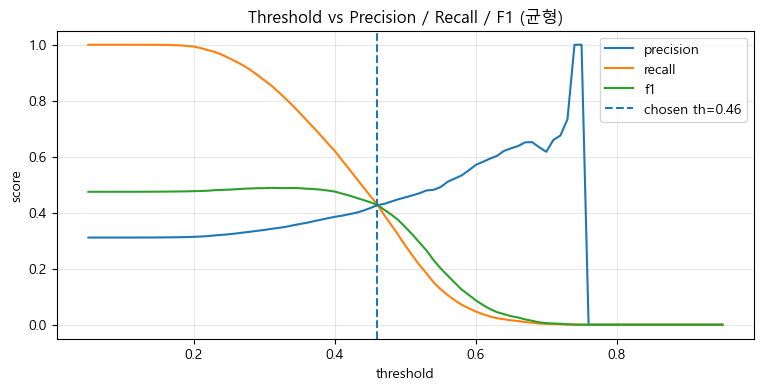

In [42]:
# ============================================================
# [단락 10] 시각화: Threshold vs Precision/Recall/F1
# ============================================================
plt.figure(figsize=(9,4))
plt.plot(tbl["th"], tbl["precision"], label="precision")
plt.plot(tbl["th"], tbl["recall"], label="recall")
plt.plot(tbl["th"], tbl["f1"], label="f1")
plt.axvline(th, linestyle="--", label=f"chosen th={th:.2f}")
plt.xlabel("threshold")
plt.ylabel("score")
plt.title("Threshold vs Precision / Recall / F1 (균형)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


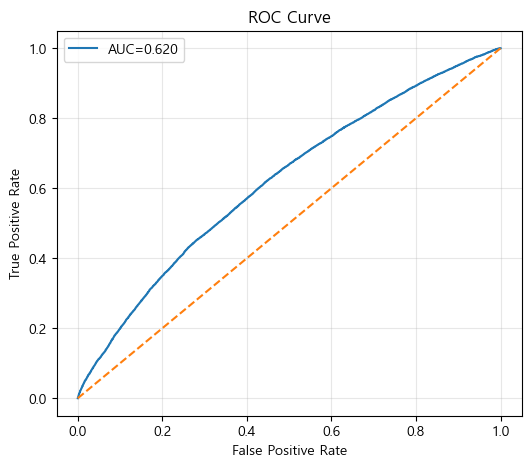

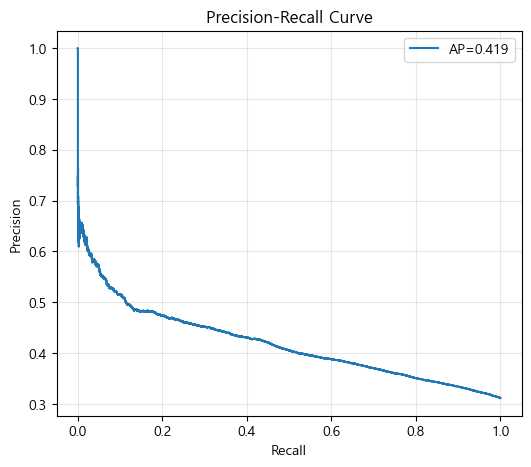

In [43]:
# ============================================================
# [단락 11] ROC / PR Curve (참고)
# ============================================================
# ROC
fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# PR
p, r, _ = precision_recall_curve(y_test, proba)
ap = average_precision_score(y_test, proba)
plt.figure(figsize=(6, 5))
plt.plot(r, p, label=f"AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [44]:
# ============================================================
# [단락 12] (선택) 구×업태별 "예측 1(폐업) 비율" / "평균 확률" 점검
#   - ✅ 폐업률(실제 평균) 계산 없음. 이진분류 예측 결과 점검용만.
# ============================================================
eval_df = X_test.copy()
eval_df["proba"] = proba
eval_df["pred"] = pred

grp_pred = (
    eval_df.groupby(["구", "업태_그룹"], as_index=False)
           .agg(
               표본수=("pred", "size"),
               예측1비율=("pred", "mean"),
               평균확률=("proba", "mean")
           )
)

grp_pred["예측1비율_pct"] = grp_pred["예측1비율"] * 100
grp_pred["평균확률_pct"] = grp_pred["평균확률"] * 100

grp_pred = grp_pred.sort_values("평균확률_pct", ascending=False).reset_index(drop=True)
grp_pred.head(20)


,구,업태_그룹,표본수,예측1비율,평균확률,예측1비율_pct,평균확률_pct
0,강동구,분식/간편식,345,0.892754,0.574713,89.275362,57.471336
1,양천구,분식/간편식,197,0.862944,0.564136,86.294416,56.413631
2,중랑구,분식/간편식,226,0.827434,0.554157,82.743363,55.415672
3,도봉구,분식/간편식,158,0.797468,0.536623,79.746835,53.662323
4,노원구,분식/간편식,266,0.789474,0.526822,78.947368,52.682232
5,은평구,분식/간편식,239,0.807531,0.526345,80.753138,52.634464
6,금천구,분식/간편식,123,0.739837,0.524683,73.983740,52.468323
7,구로구,분식/간편식,242,0.768595,0.521910,76.859504,52.191044
8,광진구,분식/간편식,258,0.686047,0.521630,68.604651,52.163017
9,강북구,분식/간편식,179,0.715084,0.517179,71.508380,51.717907


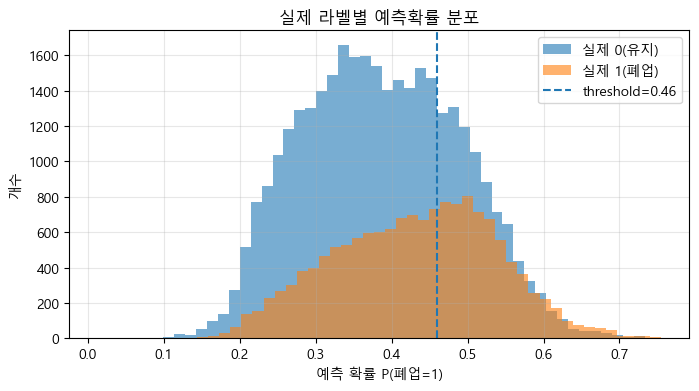

In [45]:
# ============================================================
# [단락 A] (1) 실제 라벨별 예측확률 분포 비교 (가장 기본)
#   - y=0/1이 확률 분포에서 얼마나 분리되는지 한눈에 봄
# ============================================================
plt.figure(figsize=(8,4))
plt.hist(proba[y_test==0], bins=50, alpha=0.6, label="실제 0(유지)")
plt.hist(proba[y_test==1], bins=50, alpha=0.6, label="실제 1(폐업)")
plt.axvline(th, linestyle="--", label=f"threshold={th:.2f}")
plt.xlabel("예측 확률 P(폐업=1)")
plt.ylabel("개수")
plt.title("실제 라벨별 예측확률 분포")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


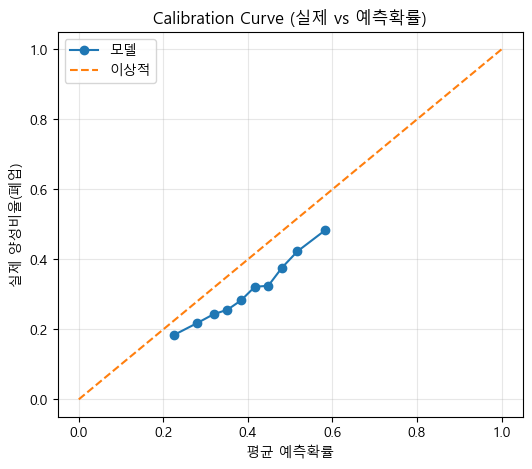

In [48]:
# ============================================================
# [단락 D] (4) 캘리브레이션(예측확률이 실제 빈도랑 맞는지) — 추천
#   - 확률값을 UI/지도에서 그대로 쓰면 이게 매우 중요함
# ============================================================
from sklearn.calibration import calibration_curve

frac_pos, mean_pred = calibration_curve(y_test, proba, n_bins=10, strategy="quantile")

plt.figure(figsize=(6,5))
plt.plot(mean_pred, frac_pos, marker="o", label="모델")
plt.plot([0,1],[0,1], linestyle="--", label="이상적")
plt.xlabel("평균 예측확률")
plt.ylabel("실제 양성비율(폐업)")
plt.title("Calibration Curve (실제 vs 예측확률)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
